In [1]:
pip install kagglehub

  Obtaining dependency information for kagglehub from https://files.pythonhosted.org/packages/c4/d1/4ab25019a168f5c414202f124d156e11ac79f07845d67288929311f1b1b2/kagglehub-0.3.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 662.2 kB/s eta 0:00:00--:--
Note: you may need to restart the kernel to use updated packages.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("domixi1989/vietnamese-receipts-mc-ocr-2021")

#설치된 경로
print("Path to dataset files:", path)

Path to dataset files: /data/ephemeral/home/.cache/kagglehub/datasets/domixi1989/vietnamese-receipts-mc-ocr-2021/versions/17


In [17]:
import os
import json
import pandas as pd
from PIL import Image
from datetime import datetime
import random

def convert_vietnamese_to_ufo(df, split):
    ufo_data = {
        "images": {}
    }
    
    for idx, row in df.iterrows():
        if pd.isna(row['anno_texts']) or pd.isna(row['anno_polygons']):
            continue
            
        img_id = row['img_id']
        img_filename = f'extractor.mc.{split}.{idx:04d}.jpg'
        
        # 다각형 정보와 텍스트 파싱
        polygons = eval(row['anno_polygons'])
        texts = str(row['anno_texts']).split('|||')
        
        words_info = {}
        
        # 각 단어에 대한 정보 생성
        for word_idx, (poly, text) in enumerate(zip(polygons, texts), 1):
            # segmentation의 처음 4개 점만 사용
            points = []
            seg_coords = poly['segmentation'][0][:8]  # 8개 좌표값 (4개 점)
            
            # points 형식으로 변환 [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
            for i in range(0, len(seg_coords), 2):
                points.append([float(seg_coords[i]), float(seg_coords[i+1])])
            
            word_info = {
                "transcription": text,
                "points": points
            }
            
            words_info[str(word_idx).zfill(4)] = word_info
        
        # 이미지 정보 생성
        image_info_ufo = {
            "words": words_info,
            "paragraphs": {},
            "chars": {},
            "img_w": poly['width'],
            "img_h": poly['height'],
            "tags": [],
            "relations": {},
            "annotation_log": {
                "worker": "worker",
                "timestamp": datetime.now().strftime("%Y-%m-%d"),
                "tool_version": "",
                "source": None
            },
            "license_tag": {
                "usability": True,
                "public": False,
                "commercial": True,
                "type": None,
                "holder": "Vietnamese Receipt Dataset"
            }
        }
        
        ufo_data["images"][img_filename] = image_info_ufo
    
    return ufo_data

# 메인 실행 코드
if __name__ == "__main__":
    # 경로 설정
    IMAGE_DIR = path + "/train_images/train_images"
    CSV_PATH = path + "/mcocr_train_df.csv"
    OUTPUT_DIR = "/data/ephemeral/home/code/data/mc_receipt"
    
    # 디렉토리 생성
    os.makedirs(os.path.join(OUTPUT_DIR, 'img/train'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'ufo'), exist_ok=True)
    
    # CSV 파일 읽기
    df = pd.read_csv(CSV_PATH)
    
    # UFO 데이터 생성
    train_data = convert_vietnamese_to_ufo(df, 'train')
    
    # 이미지 복사 및 경로 추가
    for img_filename in train_data['images'].keys():
        original_img_id = img_filename.replace('extractor.mc.train.', '').replace('.jpg', '')
        original_img_id = df.iloc[int(original_img_id)]['img_id']
        
        src_path = os.path.join(IMAGE_DIR, original_img_id)
        dst_path = os.path.join(OUTPUT_DIR, 'img/train', img_filename)
        
        # 이미지 복사
        try:
            img = Image.open(src_path)
            img.save(dst_path)
            # 이미지 경로 추가
            train_data['images'][img_filename]['img_path'] = f'train/{img_filename}'
        except Exception as e:
            print(f"Error processing image {original_img_id}: {str(e)}")
            continue
    
    # UFO 파일 저장
    with open(os.path.join(OUTPUT_DIR, 'ufo/train.json'), 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent=2)
    
    print("이미지와 UFO 데이터셋이 성공적으로 저장되었습니다.")
    
    
# train_random, val_random으로 데이터셋 분할
def split_train_val(ufo_data, train_ratio=0.8):
    # 이미지 파일명 리스트 생성
    img_filenames = list(ufo_data['images'].keys())
    
    # 랜덤하게 섞기
    random.shuffle(img_filenames)
    
    # train/val 분할 지점 계산
    split_idx = int(len(img_filenames) * train_ratio)
    
    # train과 val 데이터셋으로 분할
    train_filenames = img_filenames[:split_idx]
    val_filenames = img_filenames[split_idx:]
    
    # train_random.json 생성
    train_random = {'images': {}}
    for fname in train_filenames:
        train_random['images'][fname] = ufo_data['images'][fname]
    
    # val_random.json 생성
    val_random = {'images': {}}
    for fname in val_filenames:
        val_random['images'][fname] = ufo_data['images'][fname]
    
    return train_random, val_random

# train/val 분할 실행
train_random, val_random = split_train_val(train_data)

# train_random.json 저장
with open(os.path.join(OUTPUT_DIR, 'ufo/train_random.json'), 'w', encoding='utf-8') as f:
    json.dump(train_random, f, ensure_ascii=False, indent=2)

# val_random.json 저장  
with open(os.path.join(OUTPUT_DIR, 'ufo/val_random.json'), 'w', encoding='utf-8') as f:
    json.dump(val_random, f, ensure_ascii=False, indent=2)

print(f"Train 데이터 수: {len(train_random['images'])}")
print(f"Validation 데이터 수: {len(val_random['images'])}")

이미지와 UFO 데이터셋이 성공적으로 저장되었습니다.
Train 데이터 수: 922
Validation 데이터 수: 231


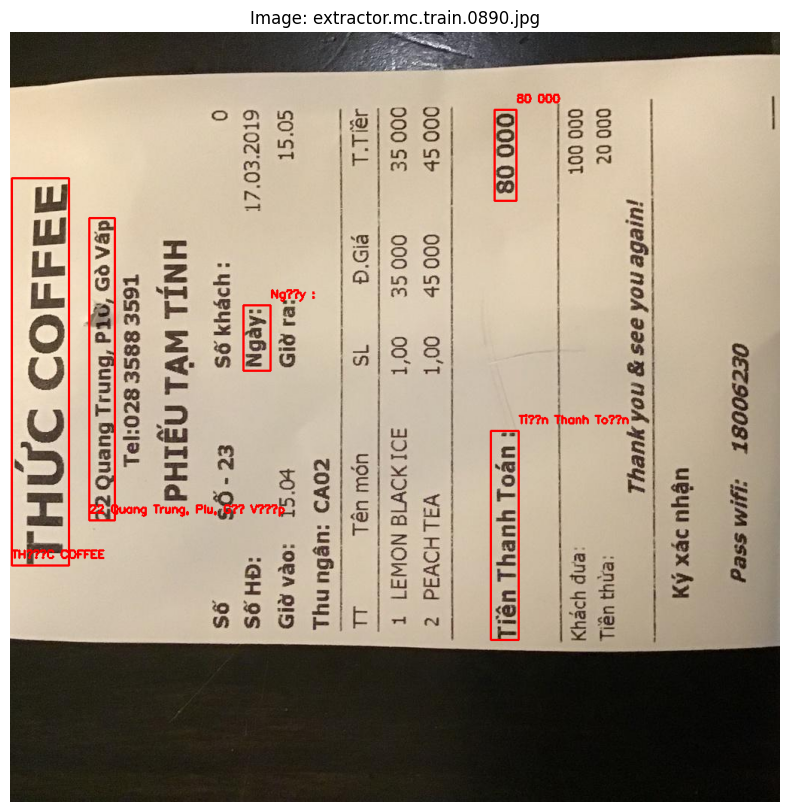

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# UFO 데이터 시각화
def visualize_ufo_data(ufo_data, image_dir):
    # 랜덤하게 이미지 선택
    img_filename = random.choice(list(ufo_data['images'].keys()))
    img_info = ufo_data['images'][img_filename]
    
    # 이미지 로드
    img_path = os.path.join(image_dir, img_info['img_path'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 시각화를 위한 이미지 복사
    vis_img = img.copy()
    
    # words에 있는 모든 바운딩 박스 그리기
    for word_info in img_info['words'].values():
        points = np.array(word_info['points'], dtype=np.int32)
        cv2.polylines(vis_img, [points], True, (255, 0, 0), 2)
        
        # 텍스트 추가
        if word_info['transcription']:
            x, y = points[0]
            cv2.putText(vis_img, word_info['transcription'], (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # 결과 시각화
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_img)
    plt.axis('off')
    plt.title(f'Image: {img_filename}')
    plt.show()

# 시각화 실행
visualize_ufo_data(train_data, OUTPUT_DIR + '/img') 

#?? Text는 시각화 에서만 나타나고 json 파일 내는 정상적으로 기록되어 있습니다.
